In [197]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
plt.style.use('ggplot')
plt.rcParams['figure.figsize']= [15, 4]

df = pd.read_excel('data/generated_daily_features.xlsx', index_col=0).loc[1961:2017]
display(df.head())

,P: debourrement - floraison,P: floraison - veraison,P: veraison - vendanges,Tn: debourrement - floraison,Tn: floraison - veraison,Tn: veraison - vendanges,Tx: debourrement - floraison,Tx: floraison - veraison,Tx: veraison - vendanges,Tm: debourrement - floraison,...,Floraison Heavy Rain,Floraison Tm,Floraison Tm-25,GDD10,P: veraison - vendanges 2,Debourrement-floraison interval,Floraison-veraison interval,Veraison-Harvest interval,Stress,Log price
1961,108.1,115.2,13.9,7.197531,13.404167,13.940426,18.328395,23.823611,25.674468,12.606173,...,0,211.3,0,2245.9,10.1,80,71,46,92.55,7.079184
1962,92.5,77.3,90.6,9.028814,13.676923,11.901852,19.383051,24.992308,24.459259,14.201695,...,0,279.2,4,2328.9,87.9,58,64,53,56.15,6.156601
1963,156.4,125.6,146.5,8.962857,13.994915,11.726984,18.821429,23.569492,20.076190,13.800000,...,0,260.1,1,2068.2,122.6,69,58,62,-110.20,5.887723
1964,158.3,43.2,98.9,9.638028,13.713115,13.916000,19.998592,25.593443,24.876000,14.692958,...,0,254.5,0,2388.7,73.5,70,60,49,68.05,5.821989
1965,141.3,63.5,278.4,9.055556,13.461224,12.073684,18.291111,23.989796,20.459649,13.584444,...,0,276.4,2,1988.8,233.7,89,48,56,0.00,5.781001


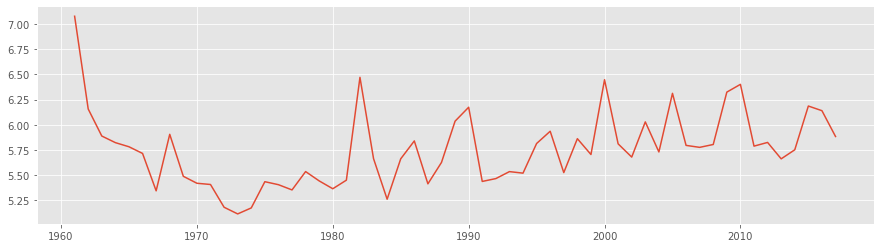

In [198]:
from sklearn.preprocessing import StandardScaler

X = df.drop('Log price', axis=1)

X['GDD10'] = X['GDD10']/1000
X['Square GDD10'] = X['GDD10']**2

#X['Square Winter Tx'] = X['Winter Tx']**2

#X['Tm Growing Season'] = np.mean(X[['Tm: floraison - veraison', 'Tm: veraison - vendanges']].values, axis=1)
X['Growing Season Tm'] = np.abs(X['Growing Season Tm']-18)

X['Square Growing Season Tm'] = X['Growing Season Tm']**2

X['Square Tn: debourrement - floraison'] = X['Tn: debourrement - floraison']**2

#X['Tm Growing Season'] = np.mean(X[['Tm: debourrement - floraison', 'Tm: floraison - veraison', 'Tm: veraison - vendanges']].values, axis=1)/16
#X['Square Tm Growing Season'] = X['Tm Growing Season']**2

#cols = [col for col in list(X.columns) if 'Tm Growing' not in col]
#X[cols] = pd.DataFrame(StandardScaler().fit_transform(X[cols]), index=X.index, columns=X[cols].columns).loc[1961:,:]

X = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns).loc[1961:,:]


COLUMN_NAMES = X.columns.to_list()
y = df[['Log price']]
plt.plot(y)

In [199]:
import torch
from tqdm.notebook import tqdm

GOOD_FEATURES = ['DTR: veraison - vendanges', 'P: veraison - vendanges', 'Stress', 'GDD10', 'Sun: veraison - vendanges', 'Heavy Rain: debourrement - floraison', 'Tn: debourrement - floraison', 'Floraison P']

init_dict = {
    'Growing Season Tm':-0.1,
    'Square Growing Season Tm':-0.1,
    'DTR: veraison - vendanges':0.2,
    'P: veraison - vendanges':-0.2,
    'Stress':0.2,
    'Floraison P':-0.1,
    'Tm: floraison - veraison':0.1,
    'Floraison-veraison interval':-0.1,
    'Tx: debourrement - floraison':0.1,
    'DTR: debourrement - floraison':-0.1,
    'Dormancy':0.1,

}

class Regressive_Model(torch.nn.Module):
    """Optimizes over the whole given dataframe"""
    def __init__(self, init_dict, length):
        super().__init__()
        
        self.weights = {}
        self.length = length
        self.type = {}
        self.weights_intercept = torch.nn.Parameter(torch.from_numpy(-0.2*np.ones(self.length)))
        
        self.walk_params = torch.nn.ParameterList([])
        for feature in GOOD_FEATURES:
            if feature in init_dict.keys():
                self.walk_params.append(torch.nn.Parameter(torch.from_numpy(init_dict[feature]*np.ones(self.length))))
            else:
                self.walk_params.append(torch.nn.Parameter(torch.from_numpy(0.1*np.random.randn(self.length))))

        self.where_to_find_walks = [COLUMN_NAMES.index(coeff_name) for coeff_name in GOOD_FEATURES]
        
        self.scalar_params = torch.nn.ParameterList([])
        self.where_to_find_scalars = [COLUMN_NAMES.index(coeff_name) for coeff_name in []]
        
    def forward(self, X):
        """ 
        Forward pass of the model on one vintage
        """
        result = torch.ones(self.length)*6
        result += self.weights_intercept
        for i in range(len(self.walk_params)):
            result += self.walk_params[i] * X[:,self.where_to_find_walks[i]]
            
        for i in range(len(self.scalar_params)):
            result += self.scalar_params[i] * X[:,self.where_to_find_scalars[i]]
        return result
    
    def loss_regularize_intercept(self):
        return torch.mean((self.weights_intercept[1:] - self.weights_intercept[:-1])*(self.weights_intercept[1:] - self.weights_intercept[:-1]))\
    /torch.max(torch.abs(self.weights_intercept))
    
    def loss_regularize_walk_coeffs(self):
        loss = 0
        for t in self.walk_params:
            loss += torch.mean((t[1:] - t[:-1])*(t[1:] - t[:-1])) / torch.max(torch.abs(t))
        return loss
    
    def loss_target(self, X, y):
        return torch.mean((y - self(X))*(y - self(X)))
    
    def combined_loss(self, X, y):
        return self.loss_target(X, y) + 10* self.loss_regularize_walk_coeffs()\
                + 10*self.loss_regularize_intercept()
                #+ self.loss_keep_close_to_prior()
    def predict_extra_vintage(self, X):
        """ 
        Predicts the vintage just after the trained range, based on data in X
        """
        result = 6
        coefficients = {}
        coefficients['intercept'] = self.weights_intercept[-1]
        result += coefficients['intercept']
        
        for i in range(len(self.walk_params)):
            coeff_name = COLUMN_NAMES[self.where_to_find_walks[i]]
            coefficients[coeff_name] = self.walk_params[i][-1]
            result += coefficients[coeff_name] * X[self.where_to_find_walks[i]]
            
        for i in range(len(self.scalar_params)):
            coeff_name = COLUMN_NAMES[self.where_to_find_scalars[i]]
            coefficients[coeff_name] = self.scalar_params[i]
            result += coefficients[coeff_name] * X[self.where_to_find_scalars[i]]
        return result, coefficients

def training_loop(model, optimizer, scheduler, n=1000):
    "Training loop for torch model."
    losses = []
    for i in tqdm(range(n)):
        loss = model.combined_loss(X_tensor, y_tensor)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        losses.append(loss)  
    return losses

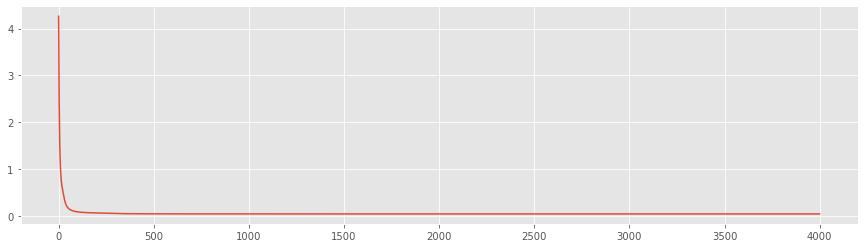

In [138]:
X_tensor = torch.FloatTensor(X.values)
y_tensor = torch.from_numpy(y['Log price'].values)

model = Regressive_Model(init_dict, len(y))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)

losses = training_loop(model, optimizer, scheduler, 4000)

plt.plot(losses)
plt.show()

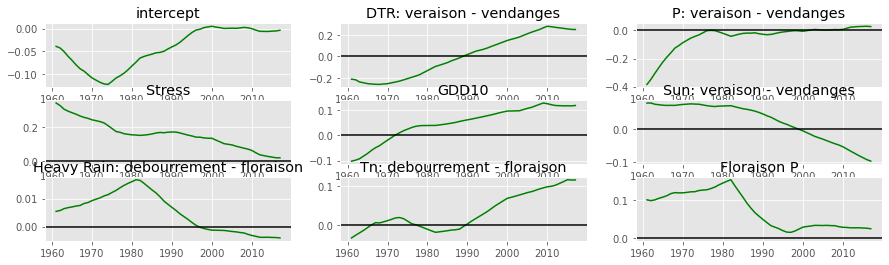

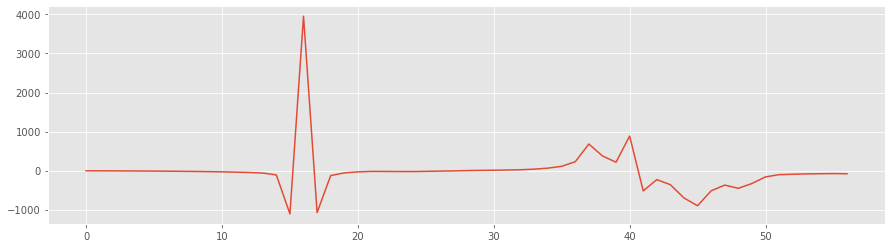

In [139]:
fig, axs = plt.subplots(3,3)
subplot = axs[0, 0]
coeff = 'intercept'
subplot.plot(range(1961, 2018), model.weights_intercept.detach().numpy(), color='green')
subplot.set_title('intercept')
for i in range(len(model.scalar_params)):
    n = i+1
    subplot = axs[n//3, n%3]
    subplot.plot(range(1961, 2018), [model.scalar_params[i]]*44, color='green').axhline(0., color='black')

    subplot.set_title(COLUMN_NAMES[model.where_to_find_scalars[i]])
    

for i in range(len(model.walk_params)):
    n = len(model.scalar_params) + i+1
    subplot = axs[n//3, n%3]

    subplot.plot(range(1961, 2018), model.walk_params[i].detach().numpy(), color='green')
    subplot.axhline(0., color='black')
    subplot.set_title(COLUMN_NAMES[model.where_to_find_walks[i]])
plt.show()

optimal_temp =  (- model.walk_params[0].detach().numpy() / (2*model.walk_params[1].detach().numpy()))*18 # x = -b/2a
plt.plot(optimal_temp)

### Avec Tm et Square Tm

Spearman correlation between results and real log prices: 
 0.6678260869565217
 
Spearman correlation between results and real log prices / full: 
 0.7168784029038113
 
### Sans Tm et square Tm
 
 Spearman correlation between results and real log prices: 
 0.7208695652173912
 
Spearman correlation between results and real log prices / full: 
 0.7192118226600986

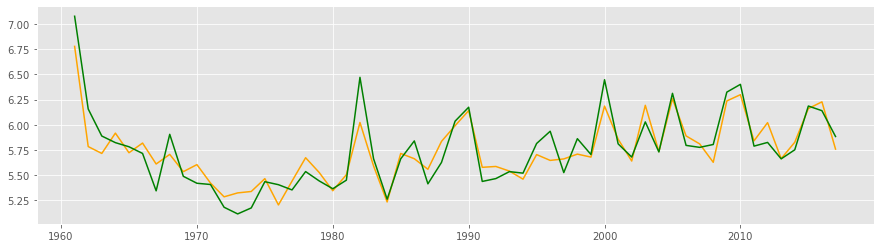

Spearman correlation between results and real log prices: 
 0.7617391304347826
Spearman correlation between results and real log prices / full: 
 0.8860513352346384


In [140]:
from scipy.stats import spearmanr
from sklearn.metrics import r2_score

full_predictions  = model(X_tensor).detach().numpy()
predictions = full_predictions[33:]

plt.plot(range(1961, 2018), full_predictions, color='orange')
plt.plot(y['Log price'], color='g')
plt.show()
print('Spearman correlation between results and real log prices: \n', spearmanr(predictions, y.loc[1994:2018, 'Log price']).correlation)
print('Spearman correlation between results and real log prices / full: \n', spearmanr(full_predictions, y.loc[1961:2018, 'Log price']).correlation)

# Ante 1994 model

Highlight the clear perf difference: continuing the line instead of just averaging the last coefficients gives a strong edge

In [211]:
from sklearn.linear_model import LinearRegression



def extrapolate_coeffs(model_coeffs_list, model_year_range, target_vintage):
    predicted_coeffs = []
    for coeffs in model_coeffs_list:
        line = LinearRegression()
        #line.fit(model_year_range, coeffs)
        line.fit(model_year_range[-15:], coeffs[-15:])
        

        predicted_coeffs.append(line.predict(np.array(target_vintage).reshape(1,-1)))
        #predicted_coeffs.append(np.mean(coeffs[-1:]))
    return predicted_coeffs

 
def predict_vintage(X, model, model_year_range, target_vintage):
    result = 6
    walk_params = [walk.detach().numpy() for walk in model.walk_params]
    model_extrapolated_walk_coeffs = extrapolate_coeffs(walk_params, model_year_range, target_vintage)
    model_extrapolated_intercept = extrapolate_coeffs([model.weights_intercept.detach().numpy()], model_year_range, target_vintage)[0]
    
    result += model_extrapolated_intercept

    for i in range(len(model_extrapolated_walk_coeffs)):
        result += model_extrapolated_walk_coeffs[i] * X[model.where_to_find_walks[i]]
    return result

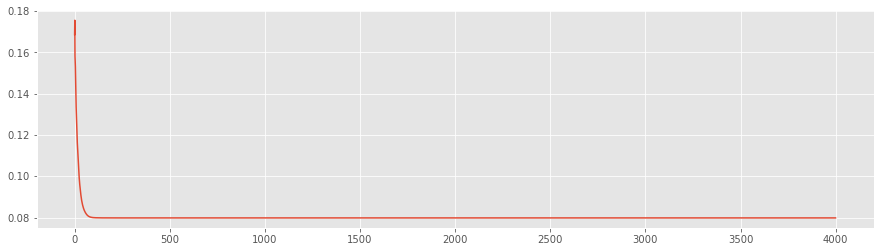

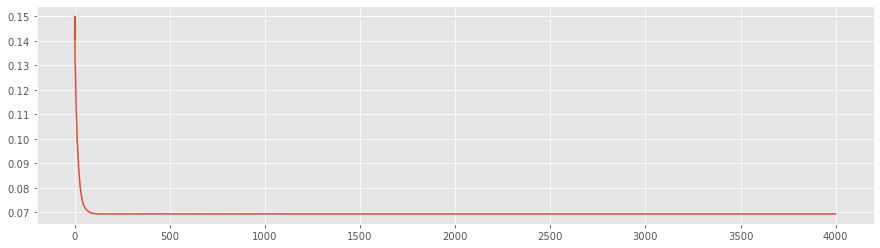

In [201]:
FIRST = 1961
LAST = 1993
from torch.optim.lr_scheduler import StepLR


X_tensor = torch.FloatTensor(X.loc[FIRST : LAST, :].values)
y_tensor = torch.from_numpy(y.loc[FIRST : LAST, 'Log price'].values)
GOOD_FEATURES = ['Stress', 'P: veraison - vendanges']

training_length = LAST - FIRST + 1
vintage_model_1994 = Regressive_Model(init_dict, training_length)
optimizer = torch.optim.Adam(vintage_model_1994.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
losses = training_loop(vintage_model_1994, optimizer, scheduler, 4000)
plt.plot(losses)
plt.show()


GOOD_FEATURES = ['Stress', 'P: veraison - vendanges']

FIRST = 1961
LAST_2 = 2004
X_tensor = torch.FloatTensor(X.loc[FIRST : LAST_2, :].values)
y_tensor = torch.from_numpy(y.loc[FIRST : LAST_2, 'Log price'].values)
    
vintage_model_2005 = Regressive_Model(init_dict, 2004-1961+1)
optimizer = torch.optim.Adam(vintage_model_2005.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=100, gamma=0.95)
losses = training_loop(vintage_model_2005, optimizer, scheduler, 4000)
plt.plot(losses)
plt.show()

In [202]:
predictions=[]
for vintage in tqdm(range(1994, 2018)):
    predictions.append(predict_vintage(
        X.loc[vintage, :],
        vintage_model_1994,
        np.array(range(FIRST, LAST + 1)).reshape(-1,1),
        vintage
                      ))
    
predictions_2=[]
for vintage in tqdm(range(2005, 2018)):
    predictions_2.append(predict_vintage(
        X.loc[vintage, :],
        vintage_model_2005,
        np.array(range(FIRST, LAST + 1)).reshape(-1,1),
        vintage
                      ))

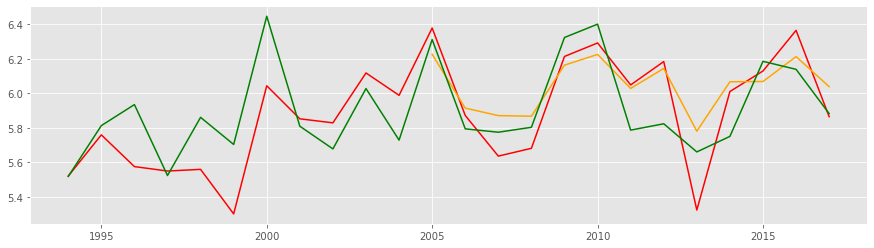

Spearman correlation between results and real log prices: first period
 0.6272727272727273
Spearman correlation between results and real log prices: second period
 0.7802197802197801
Spearman correlation between results and real log prices: second period model 2
 0.8131868131868131
Spearman correlation between results and real log prices: complete
 0.7156521739130434
MAE correlation between results and real log prices: complete
 0.32865003867305087 

Spearman correlation between results and real log prices: combined
 0.7017391304347826
MAE correlation between results and real log prices: combined
 0.29654147221650207 



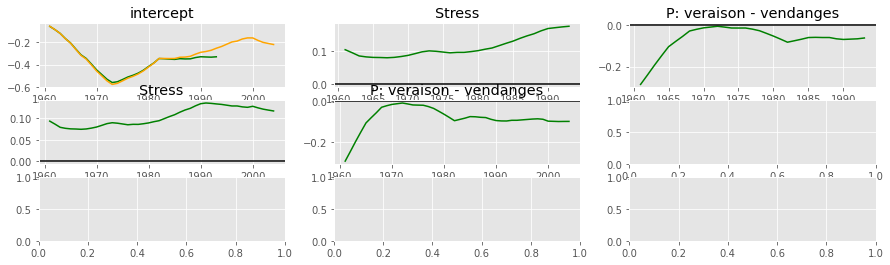

In [203]:
from scipy.stats import spearmanr
plt.plot(range(1994, 2018), predictions, color='red')
plt.plot(range(2005, 2018), predictions_2, color='orange')

plt.plot(y.loc[1994:2017, 'Log price'], color='g')
plt.show()
print('Spearman correlation between results and real log prices: first period\n', spearmanr(predictions[:11], y.loc[1994:2004, 'Log price'].values).correlation)
print('Spearman correlation between results and real log prices: second period\n', spearmanr(predictions[11:], y.loc[2005:2017, 'Log price'].values).correlation)
print('Spearman correlation between results and real log prices: second period model 2\n', spearmanr(predictions_2, y.loc[2005:2017, 'Log price'].values).correlation)

print('Spearman correlation between results and real log prices: complete\n', spearmanr(predictions, y.loc[1994:2017, 'Log price'].values).correlation)
print('MAE correlation between results and real log prices: complete\n', np.mean(np.abs(predictions- y.loc[1994:2017, 'Log price'].values)), '\n')

print('Spearman correlation between results and real log prices: combined\n', spearmanr(predictions[:11]+predictions_2, y.loc[1994:2017, 'Log price'].values).correlation)
print('MAE correlation between results and real log prices: combined\n', np.mean(np.abs(predictions[:11]+predictions_2- y.loc[1994:2017, 'Log price'].values)), '\n')

fig, axs = plt.subplots(3,3)
subplot = axs[0, 0]
coeff = 'intercept'
subplot.plot(range(FIRST, 1994), vintage_model_1994.weights_intercept.detach().numpy(), color='green')
subplot.plot(range(FIRST, 2005), vintage_model_2005.weights_intercept.detach().numpy(), color='orange')
subplot.set_title('intercept')

for i in range(len(vintage_model_1994.walk_params)):
    n =  i+1
    subplot = axs[n//3, n%3]

    subplot.plot(range(FIRST, LAST + 1), vintage_model_1994.walk_params[i].detach().numpy(), color='green')
    subplot.axhline(0., color='black')
    subplot.set_title(COLUMN_NAMES[vintage_model_1994.where_to_find_walks[i]])
    
for i in range(len(vintage_model_2005.walk_params)):
    n = len(vintage_model_1994.walk_params) + i+1
    subplot = axs[n//3, n%3]

    subplot.plot(range(FIRST, LAST_2 + 1), vintage_model_2005.walk_params[i].detach().numpy(), color='green')
    subplot.axhline(0., color='black')
    subplot.set_title(COLUMN_NAMES[vintage_model_2005.where_to_find_walks[i]])

Avec Tm et Square, en utilisant les coeffs 93:
- Spearman: 0.55


Sans Tm et Square : 
- 0.575381140598532

Le meme, avec interpolation lineaire sur tous les coeffs du modele
- 0.62

Le meme, avec interpolation lineaire sur les 10 derniers coeffs du modele
- 0.62




Spearman correlation between results and real log prices: first period
 - 0.63

Spearman correlation between results and real log prices: second period
 - 0.76

Spearman correlation between results and real log prices: complete
 - 0.69
 
# Model 1984 - 1994
 
Spearman correlation between results and real log prices: first period
 0.6545454545454547
Spearman correlation between results and real log prices: second period
 0.8727272727272729
Spearman correlation between results and real log prices: complete
 0.7368718238283457
 
 
 
# Meme periode sans GDD10 et SquareGDD10

 Spearman correlation between results and real log prices: first period
 0.6090909090909091
Spearman correlation between results and real log prices: second period
 0.8545454545454546
Spearman correlation between results and real log prices: complete
 0.7312252964426879
 
 
 # Avec meilleure loss function
 Spearman correlation between results and real log prices: first period
 0.6090909090909091
Spearman correlation between results and real log prices: second period
 0.881818181818182
Spearman correlation between results and real log prices: complete
 0.7425183512140034
 
 
# Params ['Floraison-veraison interval', 'Stress', 'P: veraison - vendanges']
 
 Spearman correlation between results and real log prices: first period
 0.6454545454545455
Spearman correlation between results and real log prices: second period
 0.8545454545454546
Spearman correlation between results and real log prices: complete
 0.7425183512140034
 
 
# Params ['Floraison-veraison interval', 'Stress', 'P: veraison - vendanges', 'DTR: veraison - vendanges']

Spearman correlation between results and real log prices: first period
 0.6545454545454547
Spearman correlation between results and real log prices: second period
 0.8090909090909091
Spearman correlation between results and real log prices: complete
 0.7594579333709771
 
 
  
# Params ['Floraison-veraison interval', 'Stress', 'DTR: veraison - vendanges', 'Tx: debourrement - floraison']
0.81

# Params ['Floraison-veraison interval', 'Stress', 'P: veraison - vendanges', 'DTR: veraison - vendanges']

Spearman correlation between results and real log prices: first period
 0.8454545454545455
Spearman correlation between results and real log prices: second period
 0.8272727272727273
Spearman correlation between results and real log prices: complete
 0.813664596273292
 
 
 
 Deuxieme essai: 0.65
 
 
 # Params ['Stress', 'DTR: veraison - vendanges']
 Spearman 0.72
 
 
 # Params ['DTR: veraison - vendanges', 'Stress', 'P: veraison - vendanges']

Spearman correlation between results and real log prices: complete
 0.706
 
 
# Stress, DTR, Floraison - veraison interval
Spearman correlation between results and real log prices: complete
0.699

# Stress tout seul
0.707

# Stress, DTR: veraison - vendanges
0.73

# Stress, P: veraison - vendanges
0.71

# Stress, DTR
0.72


# Bayesian model

In [204]:
GOOD_FEATURES = ['Stress', 'P: veraison - vendanges']


class Bayesian_Model(torch.nn.Module):
    """Optimizes over the whole given dataframe in a Bayesian way"""
    def __init__(self, init_dict, length):
        super().__init__()
        
        self.weights = {}
        self.length = length
        self.type = {}
        self.intercept_mean = torch.nn.Parameter(torch.from_numpy(-0.2*np.ones(self.length)))
        self.intercept_logvar = torch.nn.Parameter(torch.from_numpy(-4*np.ones(self.length)))

        self.walk_means = torch.nn.ParameterList([])
        for feature in GOOD_FEATURES:
            if feature in init_dict.keys():
                self.walk_means.append(torch.nn.Parameter(torch.from_numpy(init_dict[feature]*np.ones(self.length))))
            else:
                self.walk_means.append(torch.nn.Parameter(torch.from_numpy(0.2*np.random.rand(self.length))))
        
        self.where_to_find_walks = [COLUMN_NAMES.index(coeff_name) for coeff_name in GOOD_FEATURES]
        
        self.walk_logvars = torch.nn.ParameterList([])
        for feature in GOOD_FEATURES:
            self.walk_logvars.append(torch.nn.Parameter(torch.from_numpy(-4*np.ones(self.length))))

        self.scalar_params = torch.nn.ParameterList([])
        
    def sample_walks(self):
        walk_sample = []
        for i in range(len(self.walk_means)):
            walk_sample.append(self.walk_means[i] + torch.randn_like(self.walk_means[i]) * torch.exp(0.5 * self.walk_logvars[i])) # Element-wise multiplication of epsilon with variance
        return walk_sample

        
    def forward(self, X):
        """ 
        Forward pass of the model on one vintage
        """
        result = torch.ones(self.length)*6 
        result += self.intercept_mean + torch.randn_like(self.intercept_mean) * torch.exp(0.5 * self.intercept_logvar)
        
        walk_samples = self.sample_walks()
        for i in range(len(walk_samples)):
            result += walk_samples[i] * X[:,self.where_to_find_walks[i]]
            
            
        return result
    
    def loss_regularize_intercept(self):
        return torch.mean((self.intercept_mean[1:] - self.intercept_mean[:-1])*(self.intercept_mean[1:] - self.intercept_mean[:-1]))\
    /torch.max(torch.abs(self.intercept_mean))
    
    def loss_regularize_walk_coeffs(self):
        loss = 0
        for t in self.walk_means:
            loss += torch.mean((t[1:] - t[:-1])*(t[1:] - t[:-1])) / torch.max(torch.abs(t))
        return loss
    
    def loss_target(self, X, y):
        return torch.mean((y - self(X))*(y - self(X)))
    
    def combined_loss(self, X, y):
        return self.loss_target(X, y) + 10* self.loss_regularize_walk_coeffs()\
                + 10*self.loss_regularize_intercept()
                #+ self.loss_keep_close_to_prior()
        
    def predict_extra_vintage(self, X):
        """ 
        Predicts the vintage just after the trained range, based on data in X
        """
        result = 6
        coefficients = {}
        coefficients['intercept'] = self.intercept_mean[-1]
        result += coefficients['intercept']
        
        for i in range(len(self.walk_means)):
            coeff_name = COLUMN_NAMES[self.where_to_find_walks[i]]
            coefficients[coeff_name] = self.walk_means[i][-1]
            result += coefficients[coeff_name] * X[self.where_to_find_walks[i]]
            
        return result, coefficients

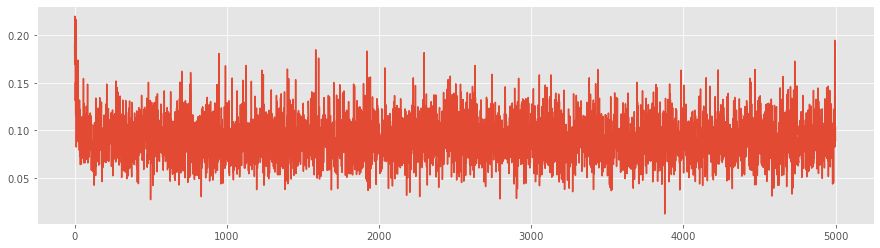

In [206]:
def training_loop_bayes(model, optimizer,scheduler, n=1000):
    "Training loop for torch model."
    losses = []
    for i in tqdm(range(n)):
        loss = model.combined_loss(X_tensor, y_tensor + 0.10*np.random.randn(len(y_tensor)))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        losses.append(loss)  
    return losses

FIRST = 1961
LAST = 1993

X_tensor = torch.FloatTensor(X.loc[FIRST : LAST, :].values)
y_tensor = torch.from_numpy(y.loc[FIRST : LAST, 'Log price'].values)
    
training_length = LAST - FIRST + 1
vintage_model_1994 = Bayesian_Model(init_dict, training_length)

optimizer = torch.optim.Adam(vintage_model_1994.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=100, gamma=0.95)

losses = training_loop_bayes(vintage_model_1994, optimizer, scheduler, 5000)
        
plt.plot(losses)
plt.show()

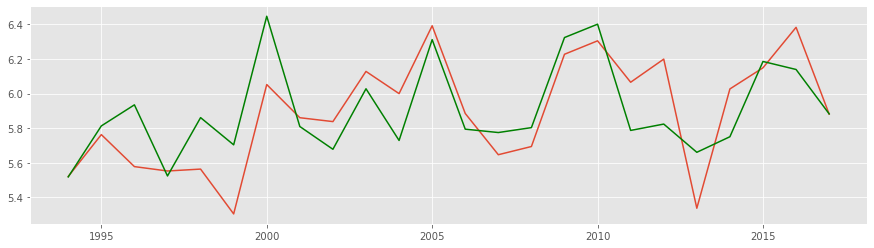

Spearman correlation between results and real log prices: first period
 0.6272727272727273
Spearman correlation between results and real log prices: second period
 0.7802197802197801
Spearman correlation between results and real log prices: complete
 0.7156521739130434


In [210]:
def predict_vintage_bayesian(X, model, model_year_range, target_vintage):
    result = 6
    walk_params = [walk.detach().numpy() for walk in model.walk_means]
    model_extrapolated_walk_coeffs = extrapolate_coeffs(walk_params, model_year_range, target_vintage)
    model_extrapolated_intercept = extrapolate_coeffs([model.intercept_mean.detach().numpy()], model_year_range, target_vintage)[0]
    
    result += model_extrapolated_intercept

    for i in range(len(model_extrapolated_walk_coeffs)):
        result += model_extrapolated_walk_coeffs[i] * X[model.where_to_find_walks[i]]
    return result

predictions=[]
for vintage in tqdm(range(1994, 2018)):
    predictions.append(predict_vintage(
        X.loc[vintage, :],
        vintage_model_1994,
        np.array(range(FIRST, LAST + 1)).reshape(-1,1),
        vintage
                      ))
    
from scipy.stats import spearmanr
plt.plot(range(1994, 2018), predictions)
plt.plot(y.loc[1994:2017, 'Log price'], color='g')
plt.show()
print('Spearman correlation between results and real log prices: first period\n', spearmanr(predictions[:11], y.loc[1994:2004, 'Log price'].values).correlation)
print('Spearman correlation between results and real log prices: second period\n', spearmanr(predictions[11:], y.loc[2005:2017, 'Log price'].values).correlation)
print('Spearman correlation between results and real log prices: complete\n', spearmanr(predictions, y.loc[1994:2017, 'Log price'].values).correlation)

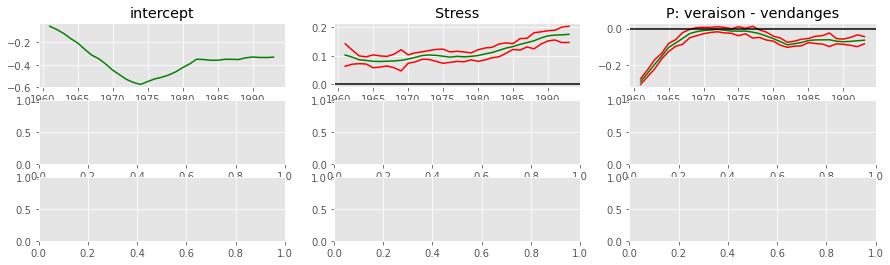

In [208]:
fig, axs = plt.subplots(3,3)
subplot = axs[0, 0]
coeff = 'intercept'
subplot.plot(range(FIRST, 1994), vintage_model_1994.intercept_mean.detach().numpy(), color='green')
subplot.set_title('intercept')

for i in range(len(vintage_model_1994.walk_means)):
    n = i+1
    subplot = axs[n//3, n%3]

    subplot.plot(range(FIRST, LAST + 1), vintage_model_1994.walk_means[i].detach().numpy() - np.exp(vintage_model_1994.walk_logvars[i].detach().numpy()), color='red')
    subplot.plot(range(FIRST, LAST + 1), vintage_model_1994.walk_means[i].detach().numpy(), color='green')
    subplot.plot(range(FIRST, LAST + 1), vintage_model_1994.walk_means[i].detach().numpy() + np.exp(vintage_model_1994.walk_logvars[i].detach().numpy()), color='red')

    subplot.axhline(0., color='black')
    subplot.set_title(COLUMN_NAMES[vintage_model_1994.where_to_find_walks[i]])

# Varying coeffs

In [213]:
import copy

def extend_tensor(tensor, extension, reduction):
    value = tensor.detach().data.clone().numpy()
    new_value = np.ones(np.size(value) + extension - reduction) * copy.deepcopy(value[-1])
    new_value[:-extension] = copy.deepcopy(value[reduction:])
    return torch.nn.Parameter(torch.from_numpy(new_value))
    
def copy_tensor(tensor):
    return torch.nn.Parameter(copy.deepcopy(tensor.detach().data.clone()), requires_grad=False)
    
class Additional_Model(torch.nn.Module):
    """Optimizes over the previous model's dataframe + one year"""
    def __init__(self, prev_model, extension, reduction, print_all = False):
        super().__init__()
        
        self.weights = {}
        self.init_dict = init_dict
        self.extension = extension
        self.reduction = reduction
        self.length = prev_model.length + (self.extension - self.reduction)
        
        self.type = {}
        self.print_all = print_all
        
        # Save init value
        self.register_buffer('init_intercept', prev_model.weights_intercept)
        self.register_buffer('init_p', prev_model.weights_p)
        self.register_buffer('init_stress', prev_model.weights_stress)
        self.register_buffer('init_dtr', prev_model.weights_dtr)
        self.init_walk_params = torch.nn.ParameterList([
            self.init_stress,
            self.init_p,
            self.init_dtr
        ])

        self.init_scalar_params = torch.nn.ParameterList(
            [])
        
        self.weights_intercept = extend_tensor(prev_model.weights_intercept, self.extension, self.reduction)
        self.weights_p = extend_tensor(prev_model.weights_p, self.extension, self.reduction)
        self.weights_stress = extend_tensor(prev_model.weights_stress, self.extension, self.reduction)
        self.weights_dtr = extend_tensor(prev_model.weights_dtr, self.extension, self.reduction)
        
        self.register_parameter('intercept', self.weights_intercept)
        self.register_parameter('Stress', self.weights_stress)
        self.register_parameter('P: veraison - vendanges', self.weights_p)
        self.register_parameter('DTR: veraison - vendanges', self.weights_dtr)
        self.walk_params = torch.nn.ParameterList([
            self.weights_stress,
            self.weights_p,
            self.weights_dtr
        ])
        self.where_to_find_walks = [COLUMN_NAMES.index(coeff_name) for coeff_name in [
            'Stress',
            'P: veraison - vendanges',
            'DTR: veraison - vendanges'
        ]]
        self.scalar_params = torch.nn.ParameterList(
            [])
        self.where_to_find_scalars = []
        
    def forward(self, X):
        """ 
        Forward pass of the model on one vintage
        """
        result = torch.ones(self.length)*6
        result += self.weights_intercept
        
        for i in range(len(self.walk_params)):
            result += self.walk_params[i] * X[:,self.where_to_find_walks[i]]
            
        for i in range(len(self.scalar_params)):
            result += self.scalar_params[i] * X[:,self.where_to_find_scalars[i]]
        return result
    
    def predict_extra_vintage(self, X):
        """ 
        Predicts the vintage just after the trained range, based on data in X
        """
        result = torch.ones(1)*6
        coefficients = {}
        coefficients['intercept'] = self.weights_intercept[-1]
        result += coefficients['intercept']
            
        for i in range(len(self.walk_params)):
            coeff_name = COLUMN_NAMES[self.where_to_find_walks[i]]
            coefficients[coeff_name] = self.walk_params[i][-1]
            result += coefficients[coeff_name] * X[self.where_to_find_walks[i]]
            
        for i in range(len(self.scalar_params)):
            coeff_name = COLUMN_NAMES[self.where_to_find_scalars[i]]
            coefficients[coeff_name] = self.scalar_params[i]
            
            result += coefficients[coeff_name] * X[self.where_to_find_scalars[i]]
        return result, coefficients
    
    def loss_regularize_walk(self):
        loss = 0
        for t in self.walk_params:
            loss += 100 * torch.mean((t[1:] - t[:-1])*(t[1:] - t[:-1]))\
                / torch.mean(t[:-1]*t[:-1])
            #loss += torch.mean((t[2:] - t[:-2])*(t[2:] - t[:-2]))
            
        #print(torch.mean(torch.abs(self.weights_intercept[1:] - self.weights_intercept[:-1])))
        loss += torch.mean((self.weights_intercept[1:] - self.weights_intercept[:-1])*(self.weights_intercept[1:] - self.weights_intercept[:-1]))\
            / torch.mean((self.weights_intercept[:-1])*(self.weights_intercept[:-1]))
        #loss += torch.mean((self.weights_stress[1:] - self.weights_stress[:-1])*(self.weights_stress[1:] - self.weights_stress[:-1]))

        #loss += torch.mean((self.weights_intercept[2:] - self.weights_intercept[:-2])*(self.weights_intercept[2:] - self.weights_intercept[:-2]))

        return loss
            
    def loss_keep_close_to_prior(self):
        loss = 0
        loss += torch.mean((self.weights_intercept[:-self.extension] - self.init_intercept[self.reduction:])*(self.weights_intercept[:-self.extension] - self.init_intercept[self.reduction:]))\
            / torch.mean(self.init_intercept[self.reduction:]*self.init_intercept[self.reduction:])
        
        for i in range(len(self.walk_params)):
            # Keep common part close
            loss += torch.mean((self.walk_params[i][:-self.extension] - self.init_walk_params[i][self.reduction:])*(self.walk_params[i][:-self.extension] - self.init_walk_params[i][self.reduction:]))\
                / torch.mean((self.init_walk_params[i][self.reduction:])*(self.init_walk_params[i][self.reduction:]))
            #loss += 100000000000*(self.walk_params[i][-1] - self.init_walk_params[i][-1])*(self.walk_params[i][-1] - self.init_walk_params[i][-1])
            # Keep the end part close - activate or not
            #loss += (self.walk_params[i][-1] - self.init_walk_params[i][-1])*(self.walk_params[i][-1] - self.init_walk_params[i][-1])
        
        for i in range(len(self.scalar_params)):
            #if self.print_all:
                #print('\n',COLUMN_NAMES[self.where_to_find_scalars[i]])
                #print(self.scalar_params[i])
                #print(self.init_scalar_params[i])
            loss += 2*torch.mean((self.scalar_params[i] -self.init_scalar_params[i])*(self.scalar_params[i] -self.init_scalar_params[i]))
        
        return loss
    
    
    def loss_target(self, X, y):
        return torch.mean((y - self(X))*(y - self(X)))
    
    def combined_loss(self, X, y):
        #print('LOSS TARGET', self.loss_target(X, y))
        #print('LOSS regwalk', self.loss_regularize_walk())
        #print('LOSS KEEP CLOSE', self.loss_keep_close_to_prior())

        return 0.0001*self.loss_target(X, y) + 0.0001*self.loss_regularize_walk() + 1*self.loss_keep_close_to_prior()

In [214]:
from tqdm import tqdm
predictions = []
coefficients_record = {}
plot=True

X_tensor = torch.FloatTensor(X.loc[1961 : 1993, :].values)
y_tensor = torch.from_numpy(y.loc[1961 : 1993, 'Log price'].values)
    
training_length = 1994-1961
vintage_model_1994 = Regressive_Model(init_dict, training_length)
optimizer = torch.optim.Adam(vintage_model_1994.parameters())
losses = training_loop(vintage_model_1994, optimizer)

result_tuple = vintage_model_1994.predict_extra_vintage(torch.FloatTensor(X.loc[1994, :].values))
prediction, coefficients  = result_tuple[0].detach().numpy(), result_tuple[1]

print(prediction)
predictions.append(prediction)
    
for coeff in list(init_dict.keys()):
    coefficients_record[coeff] = [coefficients[coeff].detach().numpy()]
    
for param in vintage_model_1994.parameters():
    param.requires_grad = False
    
intercepts= []
stresses = []
init_intercepts = []

vintage_models = [vintage_model_1994]
for vintage in tqdm(range(1995, 2016)):
    X_tensor = torch.FloatTensor(X.loc[1961 + (vintage-1994)  : vintage-1, :].values)
    y_tensor = torch.from_numpy(y.loc[1961 + (vintage-1994) : vintage-1, 'Log price'].values)
    training_length = 30
    
    last_model = Additional_Model(vintage_models[-1], 1, 1)
        
    optimizer2 = torch.optim.Adam(last_model.parameters(), lr=0.000001)
    training_loop(last_model, optimizer2, n=2000)
    #print(last_model.loss_keep_close_to_prior())
    #print('Init:\n',last_model.init_intercept)
    #print('Actual:\n',last_model.intercept)
    init_intercepts.append(last_model.init_intercept.detach().numpy())

    intercepts.append(last_model.weights_intercept.detach().numpy())
    stresses.append(last_model.weights_stress.detach().numpy())
    
    result_tuple = last_model.predict_extra_vintage(torch.FloatTensor(X.loc[vintage, :].values))
    prediction, coefficients  = result_tuple[0].detach().numpy(), result_tuple[1]
    predictions.append(prediction)
    
    last_model.zero_grad()
    vintage_models.append(last_model)
    
    for coeff in list(init_dict.keys()):
        coefficients_record[coeff].append(coefficients[coeff].detach().numpy())

TypeError: training_loop() missing 1 required positional argument: 'scheduler'

Spearman correlation between results and real log prices: 
- 0.5426312817617166


Spearman correlation between results and real log prices: 
- 0.6382947487295314

C:\Users\Rico\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\Rico\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\Rico\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different le

Spearman correlation between results and real log prices: 
 0.5403726708074535

R2 between results and real log prices: 
 -0.5443455104403361

MAE between results and real log prices: 
 [0.20170023]


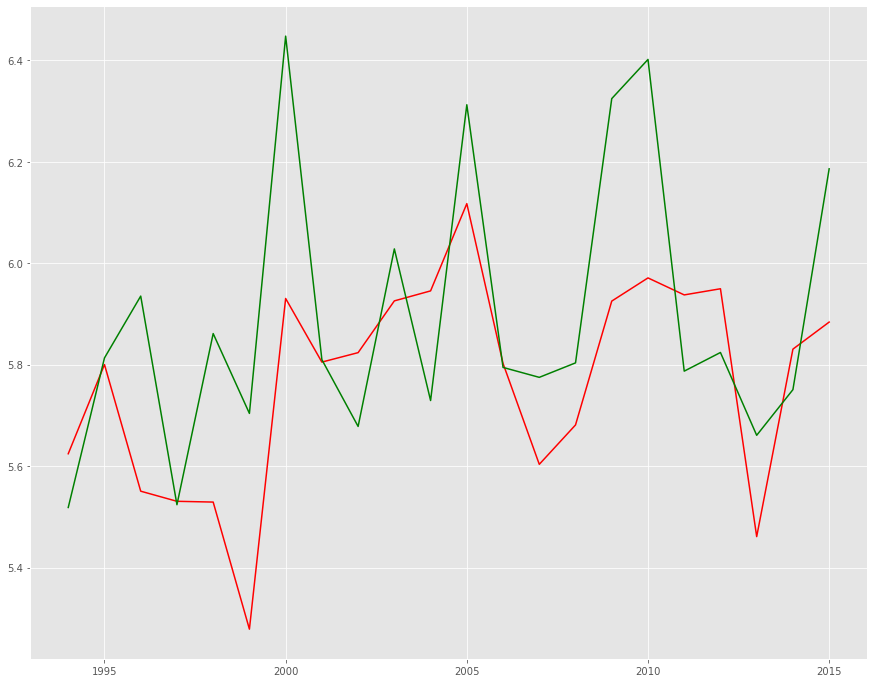

In [277]:
plt.plot(range(1994, 2016), predictions, color='r')
plt.plot(y.loc[1994:2015, 'Log price'], color='g')

print('Spearman correlation between results and real log prices: \n', spearmanr(predictions, y.loc[1994:2015, 'Log price']).correlation)
print('\nR2 between results and real log prices: \n', r2_score(predictions, y.loc[1994:2015, 'Log price']))
print('\nMAE between results and real log prices: \n', np.mean(np.abs(predictions - y.loc[1994:2015, 'Log price'])))

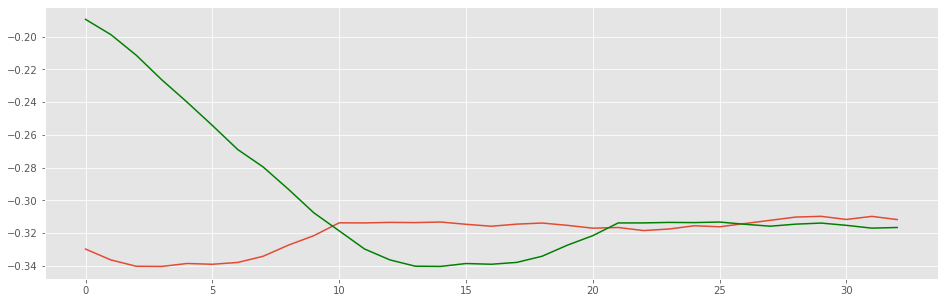

In [278]:
plt.figure(figsize=(16,5))
plt.plot(intercepts[10])
plt.plot(vintage_models[1].init_intercept.detach().numpy(), color='green')
plt.show()

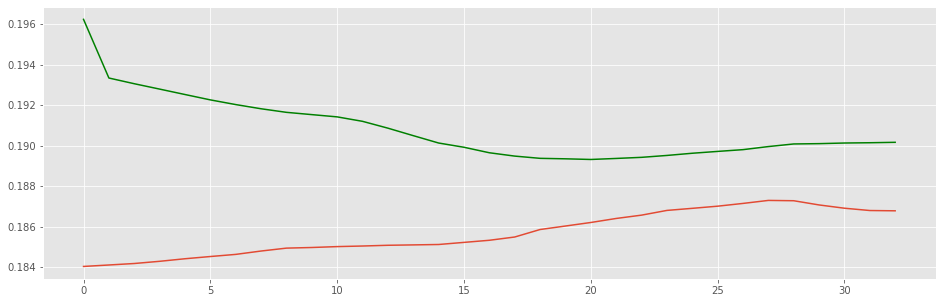

In [282]:
plt.figure(figsize=(16,5))
plt.plot(stresses[0], color='green')
plt.plot(stresses[20])
plt.show()

In [ ]:

fig, axs = plt.subplots(2,3)
print(coefficients_record.keys())
subplot = axs[0, 0]

subplot.plot(range(1961, 2018), model.weights_intercept.detach().numpy(), color='green')
subplot.plot(range(1961, 1994), vintage_model_1994.weights_intercept.detach().numpy(), color='blue')

subplot.plot(range(1995, 2017), coefficients_record['intercept'], color='orange')
subplot.set_title('intercept')
    
for i in range(len(vintage_model_1994.scalar_params)):
    n = i+1
    subplot = axs[n//3, n%3]
    coeff = COLUMN_NAMES[vintage_model_1994.where_to_find_scalars[i]]
    subplot.plot(range(1961, 1994), [model.scalar_params[i]]*44, color='green')
    subplot.plot(range(1961, 1994), [vintage_model_1994.scalar_params[i]]*44, color='blue')

    subplot.plot(range(1995, 2017), coefficients_record[coeff], color='orange')
    subplot.set_title(COLUMN_NAMES[vintage_model_1994.where_to_find_scalars[i]])

    
for i in range(len(vintage_model_1994.walk_params)):
    n = len(vintage_model_1994.scalar_params) + i+1
    subplot = axs[n//3, n%3]
    coeff = COLUMN_NAMES[vintage_model_1994.where_to_find_walks[i]]

    subplot.plot(range(1961, 2018), model.walk_params[i].detach().numpy(), color='green')
    subplot.plot(range(1961, 1994), vintage_model_1994.walk_params[i].detach().numpy(), color='blue')

    subplot.plot(range(1995, 2017), coefficients_record[coeff], color='orange')
    subplot.set_title(COLUMN_NAMES[vintage_model_1994.where_to_find_walks[i]])



# Second all mobile coeffs model

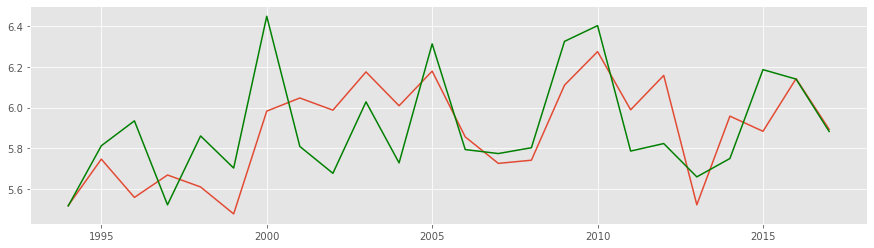

Spearman correlation between results and real log prices: first period
 0.33636363636363636
Spearman correlation between results and real log prices: second period
 0.7032967032967032
Spearman correlation between results and real log prices: complete
 0.5791304347826086


In [212]:
from torch.optim.lr_scheduler import StepLR

predictions=[]
for vintage in range(1994, 2018):
    print(vintage)
    FIRST = 1961
    LAST = vintage - 1
    
    X_tensor = torch.FloatTensor(X.loc[FIRST : LAST, :].values)
    y_tensor = torch.from_numpy(y.loc[FIRST : LAST, 'Log price'].values)
    GOOD_FEATURES = ['Stress', 'P: veraison - vendanges']
    
    training_length = LAST - FIRST + 1
    vintage_model = Regressive_Model(init_dict, training_length)
    optimizer = torch.optim.Adam(vintage_model.parameters(), lr=0.01)
    scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
    losses = training_loop(vintage_model, optimizer, scheduler, 4000)
    
    predictions.append(predict_vintage(
        X.loc[vintage, :],
        vintage_model,
        np.array(range(FIRST, LAST + 1)).reshape(-1,1),
        vintage))
    
plt.plot(range(1994, 2018), predictions)
plt.plot(y.loc[1994:2017, 'Log price'], color='g')
plt.show()
print('Spearman correlation between results and real log prices: first period\n', spearmanr(predictions[:11], y.loc[1994:2004, 'Log price'].values).correlation)
print('Spearman correlation between results and real log prices: second period\n', spearmanr(predictions[11:], y.loc[2005:2017, 'Log price'].values).correlation)
print('Spearman correlation between results and real log prices: complete\n', spearmanr(predictions, y.loc[1994:2017, 'Log price'].values).correlation)